In [ ]:
# Imports
# TODO: Add a thing that checks in on the enviorment to see if it isn't improving any longer and stops that epoch

%load_ext autoreload
%autoreload 2

import gymnasium as gym
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras as ks
import random
import matplotlib.pyplot as plt
import time
from tensorflow.keras import layers
import SquarePacking.env
# !pip install -e SquarePacking
# from ReplayBuffer import ReplayBuffer

In [72]:
# Configuration & Enviorment

# I don't need it to be determinisitic
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

# Set up the enviorment
env = gym.make("SquarePacking/Square-v0", N=5, search_space=10, render_mode="pygame", shift_rate=.05, rot_rate=.03, max_steps=300, bound_method='loop', flatten=True, boundary=2, max_overlap=.1)

num_states = np.product(env.observation_space.shape)
print("Size of State Space -> {}".format(num_states))
num_actions = np.product(env.action_space.shape)
print("Size of Action Space -> {}".format(num_actions))

upper_bound = env.action_space.high
lower_bound = env.action_space.low

print("Max Value of an Action -> {}".format(upper_bound))
print("Min Value of an Action -> {}".format(lower_bound))

Size of State Space -> 15
Size of Action Space -> 15
Max Value of an Action -> [0.05 0.05 0.03 0.05 0.05 0.03 0.05 0.05 0.03 0.05 0.05 0.03 0.05 0.05
 0.03]
Min Value of an Action -> [-0.05 -0.05 -0.03 -0.05 -0.05 -0.03 -0.05 -0.05 -0.03 -0.05 -0.05 -0.03
 -0.05 -0.05 -0.03]


In [58]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self, std=None):
        if std is None: 
            std = self.std_dev
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + std * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

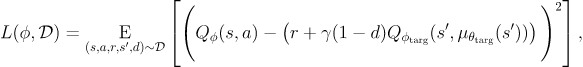

In [59]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, state, action, reward, next_state):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = state
        self.action_buffer[index] = action
        self.reward_buffer[index] = reward
        self.next_state_buffer[index] = next_state

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):
        # Training and updating Actor & Critic networks. 
        with tf.GradientTape() as tape:
            # What we think we should do
            target_actions = target_actor(next_state_batch, training=True)
            # How good we think that is (the target Q-Network)
            target_evaluation = target_critic([next_state_batch, target_actions], training=True)
            y = reward_batch + gamma * target_evaluation
            critic_value = critic_model([state_batch, action_batch], training=True)
            # Get the average amount we were off by in predicting how well we would do, squared, and that's the loss
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)

# This updates target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


In [60]:
# Define Actor & Critic Models
# Tells a later cell to reset the weights (since we might have changed how we initialize them in this cell)
INIT_WEIGHTS = False 

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    # last_init = tf.random_uniform_initializer(minval=-env.shift_rate, maxval=env.shift_rate)
    # last_init = tf.random_uniform_initializer(minval=-3e-4, maxval=3e-4)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="leaky_relu")(inputs)
    out = layers.Dense(256, activation="leaky_relu")(out)
    # outputs = layers.Dense(num_actions, activation='softsign', kernel_initializer=last_init)(out)
    outputs = layers.Dense(num_actions, activation='softsign')(out)

    # This is rescale the output from between -1 - 1 to the appropriate action space scale
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    # model.summary()
    return model

# Exactly the same, but using Sequential, which I understand better
def get_actor_seq():
    # Initialize weights
    last_init = tf.random_uniform_initializer(minval=-env.shift_rate, maxval=env.shift_rate)
    # last_init = tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3)

    model = tf.keras.Sequential([
        layers.Dense(64, activation="leaky_relu", input_shape=(num_states,)),
        layers.Dense(128, activation="leaky_relu"),
        layers.Dense(256, activation="leaky_relu"),
        layers.Dense(64, activation="leaky_relu"),
        layers.Dense(num_actions, kernel_initializer=last_init),
        # layers.Dense(num_actions, activation='softmax'),
        # This is rescale the output from between -1 - 1 to the appropriate action space scale
        layers.Lambda(lambda x: x * upper_bound)
    ])

    # model.summary()
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="leaky_relu")(state_input)
    state_out = layers.Dense(32, activation="leaky_relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="leaky_relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="leaky_relu")(concat)
    out = layers.Dense(256, activation="leaky_relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)
    # model.summary()
    return model
    
# Again, same thing but using Sequential instead
def get_critic_seq():
    state_model = tf.keras.Sequential([
        layers.Dense(128, activation="leaky_relu", input_shape=(num_states,)),
        layers.Dense(256, activation="leaky_relu")
    ])

    action_model = tf.keras.Sequential([
        layers.Dense(128, activation="leaky_relu", input_shape=(num_actions,)),
        layers.Dense(256, activation="leaky_relu")
    ])

    concat = layers.Concatenate()([state_model.output, action_model.output])
    out = layers.Dense(400, activation="leaky_relu")(concat)
    out = layers.Dense(600, activation="leaky_relu")(out)
    outputs = layers.Dense(1, activation='softmax')(out) #, activation='tanh'

    model = tf.keras.Model(inputs=[state_model.input, action_model.input], outputs=outputs)
    # model.summary()
    return model


In [70]:
# Config
actor_weights_file = 'actor_weights'
critic_weights_file = 'critic_weights'

target_actor_weights_file = 'target_actor_weights'
target_critic_weights_file = 'target_critic_weights'

load_weights = False
loat_target_weights = False

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

if load_weights:
    actor_model.load_weights(actor_weights_file)
    critic_model.load_weights(critic_weights_file)

if loat_target_weights:
    target_actor.load_weights(target_actor_weights_file)
    target_critic.load_weights(target_critic_weights_file)
else:
    # Making the weights equal initially
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.0015

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

buffer = Buffer(50000, 64)

total_episodes = 100
# Discount factor for future rewards
patience = gamma = 0.99
# Used to update target networks
tau = 0.005

std_dev = 0.2 # was .2
# noise = OUActionNoise(mean=np.zeros(1), std_deviation=std_dev * np.ones(1))
noise = lambda std=std_dev: np.random.normal(scale=std, size=env.action_space.shape)
add_noise = True
noise_cooldown = actor_lr * 4

reset_weights = True

if not INIT_WEIGHTS:
    actor_model.save_weights('actor_model_init.h5')
    critic_model.save_weights('critic_model_init.h5')
    target_actor.save_weights('target_actor_init.h5')
    target_critic.save_weights('target_critic_init.h5')
    INIT_WEIGHTS = True


In [73]:
# Main Loop
if reset_weights:
    actor_model.load_weights('actor_model_init.h5')
    critic_model.load_weights('critic_model_init.h5')
    target_actor.load_weights('target_actor_init.h5')
    target_critic.load_weights('target_critic_init.h5')

# To store reward history of each episode (for plotting)
ep_reward_list = []
# To store average reward history of last few episodes (for plotting)
avg_reward_list = []

try:
    # Run through `total_episodes` number of enviorment resets
    for ep in range(total_episodes):
        prev_state, _ = env.reset()
        # The /env.search_space here (and after step()) is to normalize the values to within 0-1 so the NN can interpret them
        # Note that this assumes the search_space is greater than pi/2 (which shouldn't be a problem)
        prev_state = np.array([prev_state])/env.search_space
        episodic_reward = 0
        cnt = 0

        # Run/step through a single episodes
        while True:
            cnt += 1
            # Slow it down so I can see it doing things
            # time.sleep(.1)
            # Show the enviorment (comment this out to run headless)
            env.render()
            env.print(f'State: {state}')

            # This is the policy -- deciding what action to take
            # Get the main actor output (i.e. "which action do I think we should take?")
            sampled_actions = tf.squeeze(actor_model(prev_state)).numpy()
            env.print(f'Action: {sampled_actions}')
            if add_noise:
                # This should make the noise fade out over time (proportional to the actor learning rate)
                # We want to fade the noise over time, *and* as we step through specific episodes
                total_cooldown   = max(std_dev - (ep  * noise_cooldown), 0)
                episode_cooldown = max(std_dev - (cnt * noise_cooldown), 0)
                sampled_actions += noise((total_cooldown + episode_cooldown) / 2)
                # sampled_actions += noise(max(std_dev - (cnt * noise_cooldown), 0))
                env.print(f'Action + noise: {sampled_actions}')
                
            # Make sure action is the action space 
            action = np.clip(sampled_actions, lower_bound, upper_bound)

            # Recieve state and reward from environment.
            state, reward, done, _, info = env.step(action)
            state = np.array([state])/env.search_space
            env.print(f'Fresh State: {state}')

            buffer.record(prev_state, action, reward, state)
            episodic_reward += reward

            # This is where the Bellman equation is implemented
            buffer.learn()
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)

            if done:
                break

            prev_state = state

        # Episode is done, now do some calculations
        # These are all just for plotting, not actually important to the algorithm
        ep_reward_list.append(episodic_reward)
        # Mean of last 40 episodes
        avg_reward = np.mean(ep_reward_list[-40:])
        avg_reward_list.append(avg_reward)
        print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    
finally:
    env.close()

Episode * 0 * Avg Reward is ==> 51568.1049975111
Episode * 1 * Avg Reward is ==> 122763.95649623811
Episode * 2 * Avg Reward is ==> 100810.14639118737
Episode * 3 * Avg Reward is ==> 128681.41137650133
Episode * 4 * Avg Reward is ==> 149695.45642299173
Episode * 5 * Avg Reward is ==> 161387.27910446527
Episode * 6 * Avg Reward is ==> 172883.080142939
Episode * 7 * Avg Reward is ==> 184980.44190821348
Episode * 8 * Avg Reward is ==> 191471.6229343308
Episode * 9 * Avg Reward is ==> 193209.78950266022
Episode * 10 * Avg Reward is ==> 192194.67224670344
Episode * 11 * Avg Reward is ==> 186996.39442286536
Episode * 12 * Avg Reward is ==> 184265.0690208532
Episode * 13 * Avg Reward is ==> 182913.75033782233
Episode * 14 * Avg Reward is ==> 184845.26297492327
Episode * 15 * Avg Reward is ==> 189448.4160353851
Episode * 16 * Avg Reward is ==> 188981.56223495599
Episode * 17 * Avg Reward is ==> 189373.2811117411
Episode * 18 * Avg Reward is ==> 190958.88297679622
Episode * 19 * Avg Reward is =

KeyboardInterrupt: 

: 

In [ ]:
# Plotting Episodes versus Avg. Rewards graph 
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
# Save the weights
actor_model.save_weights(actor_weights_file)
critic_model.save_weights(critic_weights_file)

target_actor.save_weights(target_actor_weights_file)
target_critic.save_weights(target_critic_weights_file)